## Taylor Swift Lyrics Analysis Project

This project focuses on the songs from Taylor Swift's 7 studio albums (self-titled, Fearless, Speak Now, Red, 1989, reputation and Lover). On Kaggle, I found a dataset uploaded by PromptCloud who collected the lyrics of the first 6 albums (from self-titled to reputation). For Taylor's newest album Lover, I scraped the lyrics pages of songs in this album on https://www.azlyrics.com/. 

Kaggle dataset link: https://www.kaggle.com/PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums

In [204]:
# Data processing and visualization libs
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt

# Web scraping libs
import requests
from bs4 import BeautifulSoup

# NLP libs
import nltk
import nltk.corpus
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Part I: Get the lyrics

In [3]:
# The Kaggle dataset is named taylor_swift_lyrics.csv. Read in the lyrics of first 6 albums
lyrics = pd.read_csv('taylor_swift_lyrics.csv')

# Each row of this dataset is one single line of lyrics of each song, which is not what we want.
lyrics.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


In [52]:
# Concatenate the lyrics of each songs using groupby
songs_part1 = lyrics[['album', 'track_title', 'lyric']].groupby(['album', 'track_title']).agg({'lyric': lambda x: x.str.cat(sep = ' ')}).reset_index()
songs_part1.head()

,album,track_title,lyric
0,1989,All You Had to Do Was Stay,People like you always want back The love they...
1,1989,Bad Blood,"'Cause baby, now we've got bad blood You know ..."
2,1989,Blank Space,"Nice to meet you, where you been? I could show..."
3,1989,Clean,The drought was the very worst When the flower...
4,1989,How You Get The Girl,"Uh, uh, uh Uh, uh, uh Uh-uh, uh-uh Stand there..."


In [14]:
# Before we continue, we need to get the lyrics of songs in album Lover

# I found a website (https://www.azlyrics.com) that provides the lyrics of songs in Lover
# The root_url is the lyrics page of the first song 'I Forgot That You Existed' in album Lover
# This page also contains all the other lyrics pages' links on https://www.azlyrics.com
# I scraped this page to get all the lyrics pages' links
root_url = 'https://www.azlyrics.com/lyrics/taylorswift/iforgotthatyouexisted.html'
root_html = requests.get(root_url)
root_bs = BeautifulSoup(root_html.text, 'html.parser')

In [15]:
# Store each song's title in lover_track_title
lover_track_title = [track.get_text() for track in root_bs.find_all('div', class_= 'panel songlist-panel noprint')[0].find_all('a')]

In [16]:
# Store each song's lyrics page link in lover_track_url
lover_track_url = ['https://www.azlyrics.com/lyrics/taylorswift/' + track['href'] for track in root_bs.find_all('div', class_= 'panel songlist-panel noprint')[0].find_all('a')]

In [238]:
lover_track_url

['https://www.azlyrics.com/lyrics/taylorswift/iforgotthatyouexisted.html',
 'https://www.azlyrics.com/lyrics/taylorswift/cruelsummer.html',
 'https://www.azlyrics.com/lyrics/taylorswift/lover.html',
 'https://www.azlyrics.com/lyrics/taylorswift/theman.html',
 'https://www.azlyrics.com/lyrics/taylorswift/thearcher.html',
 'https://www.azlyrics.com/lyrics/taylorswift/ithinkheknows.html',
 'https://www.azlyrics.com/lyrics/taylorswift/missamericanatheheartbreakprince.html',
 'https://www.azlyrics.com/lyrics/taylorswift/paperrings.html',
 'https://www.azlyrics.com/lyrics/taylorswift/corneliastreet.html',
 'https://www.azlyrics.com/lyrics/taylorswift/deathbyathousandcuts.html',
 'https://www.azlyrics.com/lyrics/taylorswift/londonboy.html',
 'https://www.azlyrics.com/lyrics/taylorswift/soonyoullgetbetter.html',
 'https://www.azlyrics.com/lyrics/taylorswift/falsegod.html',
 'https://www.azlyrics.com/lyrics/taylorswift/youneedtocalmdown.html',
 'https://www.azlyrics.com/lyrics/taylorswift/after

In [24]:
# Create a new dataframe lover to store the lyrics data of album Lover
lover = pd.DataFrame(index = range(0, len(lover_track_url)), columns = ['album', 'track_title', 'lyric'])
lover['album'] = 'Lover'
lover['track_title'] = lover_track_title

# Scrape each song's lyrics page, get the lyrics, tokenize them and store the data
for t in range(0, len(lover_track_title)):
    url = lover_track_url[t]
    html = requests.get(url)
    bs = BeautifulSoup(html.text, 'html.parser')
    lover.loc[t, 'lyric'] = bs.find_all('div')[9].find_all('div')[9].get_text()

# There are some \n and \r in the data (at the beginning for example) and we need to remove them
lover.head()

,album,track_title,lyric
0,Lover,I Forgot That You Existed,\n\r\nHow many days did I spend thinking\n'Bou...
1,Lover,Cruel Summer,"\n\r\n(Yeah, yeah, yeah, yeah)\n\nFever dream ..."
2,Lover,Lover,\n\r\nWe could leave the Christmas lights up '...
3,Lover,The Man,"\n\r\nI would be complex, I would be cool\nThe..."
4,Lover,The Archer,\n\r\nCombat\nI'm ready for combat\nI say I do...


In [25]:
# Replace the \n and \r with blankspaces to avoid unwanted concatenation
lover['lyric'] = lover['lyric'].apply(lambda x: x.replace('\n', ' ').replace('\r', ' '))
lover.head()

,album,track_title,lyric
0,Lover,I Forgot That You Existed,How many days did I spend thinking 'Bout ho...
1,Lover,Cruel Summer,"(Yeah, yeah, yeah, yeah) Fever dream high ..."
2,Lover,Lover,We could leave the Christmas lights up 'til...
3,Lover,The Man,"I would be complex, I would be cool They'd ..."
4,Lover,The Archer,Combat I'm ready for combat I say I don't w...


In [233]:
# So far, we have successfully collected the lyrics data of album Lover and are ready to join it with the previous dataset songs
# Append lover to songs
songs = songs_part1.append(lover, ignore_index = True)

# Prepare an albums dataset containing lyrics grouped by each album
albums = songs[['album', 'lyric']].groupby('album').agg({'lyric':lambda x: x.str.cat(sep = ' ')}).reset_index()

## Part II: Preprocess the lyrics

In [212]:
# Tokenize the lyrics: break the lyrics into single lowercase words instead of sentences.
songs['lyric'] = songs['lyric'].apply(lambda x: x.lower().split(sep = ' '))
songs.head()

,album,track_title,lyric
0,1989,All You Had to Do Was Stay,"[people, like, you, always, want, back, the, l..."
1,1989,Bad Blood,"['cause, baby,, now, we've, got, bad, blood, y..."
2,1989,Blank Space,"[nice, to, meet, you,, where, you, been?, i, c..."
3,1989,Clean,"[the, drought, was, the, very, worst, when, th..."
4,1989,How You Get The Girl,"[uh,, uh,, uh, uh,, uh,, uh, uh-uh,, uh-uh, st..."


In [213]:
# Remove the blankspaces used to replace \n and \r
songs['lyric'] = songs['lyric'].apply(lambda xs: [x for x in xs if x not in [' ', '']])

In [214]:
# Get the total counts of words
songs['total_count'] = songs['lyric'].apply(len)

In [215]:
# Remove punctuations.
songs['lyric'] = songs['lyric'].apply(lambda xs: [x.translate(str.maketrans('', '', string.punctuation)) for x in xs])

In [216]:
# Remove stopwords.
stop_words = set(stopwords.words('english'))
songs['lyric'] = songs['lyric'].apply(lambda xs: [x for x in xs if x not in stop_words])

In [217]:
# Lemmatize each word.
lm = WordNetLemmatizer()
songs['lyric'] = songs['lyric'].apply(lambda xs: [lm.lemmatize(x) for x in xs])

In [218]:
songs.sort_values(by = 'total_count', ascending = False).head()

,album,track_title,lyric,total_count
85,reputation,End Game (Ft. Ed Sheeran & Future),"[future, wanna, end, game, wanna, first, strin...",719
8,1989,Out of the Woods,"[looking, seems, simple, lying, couch, remembe...",652
9,1989,Shake It Off,"[stay, late, got, nothing, brain, thats, peopl...",595
6,1989,I Wish You Would,"[200, car, window, pas, street, memory, start,...",563
90,reputation,Look What You Made Me Do,"[dont, like, little, game, dont, like, tilted,...",557


## Part III: Exploratory data analysis

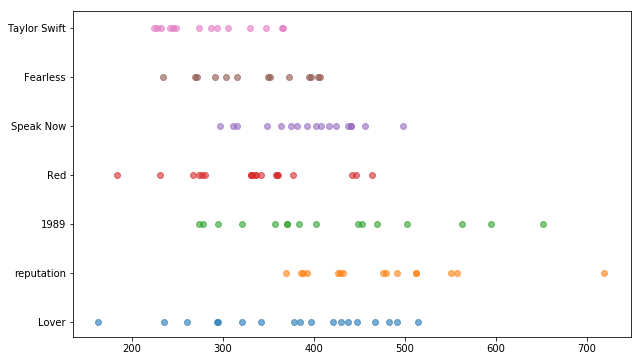

In [184]:
# This scatterplot presents the lyrics counts of songs by album
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
album_title = ['Lover', 'reputation', '1989', 'Red', 'Speak Now', 'Fearless', 'Taylor Swift']
for i in album_title:
    ax.scatter(x = songs.loc[songs.album == i, 'total_count'], y = songs.loc[songs.album == i,'album'], alpha = 0.6)

In [193]:
# We want to know how many unique non-stopword each song uses
songs['unique_count'] = songs['lyric'].apply(lambda x: len(np.unique(x)))

# Divide the unique_count by total_count to better understand how repetitive each song's lyrics is
songs['sparsity'] = songs['unique_count']/songs['total_count']

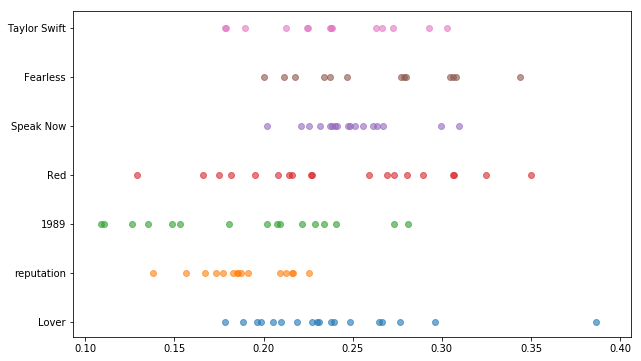

In [195]:
# This scatterplot presents the lyrics sparsity of songs by album
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
album_title = ['Lover', 'reputation', '1989', 'Red', 'Speak Now', 'Fearless', 'Taylor Swift']
for i in album_title:
    ax.scatter(x = songs.loc[songs.album == i, 'sparsity'], y = songs.loc[songs.album == i,'album'], alpha = 0.6)

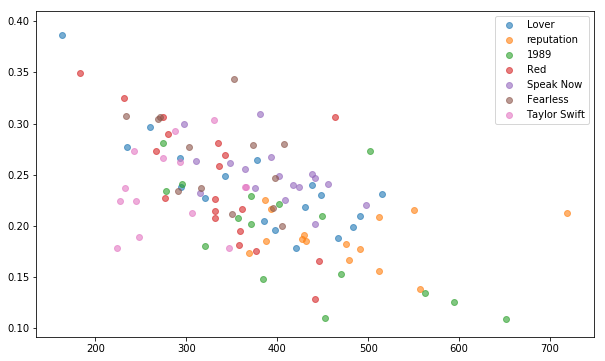

In [199]:
# Plot total_count against sparsity
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
for i in album_title:
    ax.scatter(x = songs.loc[songs.album == i, 'total_count'], y =songs.loc[songs.album == i, 'sparsity'], alpha = 0.6)
ax.legend(album_title)

In [265]:
# Write a csv file to store the data for visualization in Tableau
songs[['album', 'track_title', 'total_count', 'unique_count', 'sparsity']].to_csv('ts_lyrics.csv')

In [202]:
albums = songs[['album', 'lyric']].groupby('album').agg({'lyric':lambda x: sum(x, [])}).reset_index()
albums

,album,lyric
0,Lover,"[love, cruel, city, lived, everyone, looked, w..."
1,reputation,"[castle, crumbled, overnight, brought, knife, ..."
2,1989,"[people, like, always, want, back, love, gave,..."
3,Red,"[said, simple, way, 4, second, day, strange, d..."
4,Speak Now,"[still, remember, look, face, lit, darkness, 1..."
5,Fearless,"[take, deep, breath, walk, door, morning, firs..."
6,Taylor Swift,"[cant, see, way, eye, light, smile, shell, nev..."


### Album lyrics

In [234]:
albums['lyric'] = albums['lyric'].apply(lambda x: x.lower().split(sep = ' '))
albums['lyric'] = albums['lyric'].apply(lambda xs: [x.translate(str.maketrans('', '', string.punctuation)) for x in xs if x not in [' ', '']])
albums['total_count'] = albums['lyric'].apply(len)
albums['lyric'] = albums['lyric'].apply(lambda xs: [x for x in xs if x not in stop_words])
albums['lyric'] = albums['lyric'].apply(lambda xs: [lm.lemmatize(x) for x in xs])
albums['unique_count'] = albums['lyric'].apply(lambda x: len(np.unique(x)))
albums['sparsity'] = albums['unique_count']/albums['total_count']
albums['freq'] = albums['lyric'].apply(collections.Counter)

In [237]:
albums

,album,lyric,total_count,unique_count,sparsity,freq
0,1989,"[people, like, always, want, back, love, gave,...",6737,698,0.103607,"{'people': 11, 'like': 42, 'always': 6, 'want'..."
1,Fearless,"[see, face, mind, drive, away, cause, none, u,...",4363,601,0.137749,"{'see': 21, 'face': 2, 'mind': 4, 'drive': 4, ..."
2,Lover,"[many, day, spend, thinking, bout, wrong, wron...",6761,869,0.128531,"{'many': 2, 'day': 5, 'spend': 1, 'thinking': ..."
3,Red,"[feel, like, perfect, night, dress, like, hips...",6326,779,0.123143,"{'feel': 15, 'like': 91, 'perfect': 3, 'night'..."
4,Speak Now,"[im, glad, made, time, see, hows, life, tell, ...",6709,855,0.127441,"{'im': 46, 'glad': 2, 'made': 10, 'time': 29, ..."
5,Taylor Swift,"[would, wanna, break, perfectly, good, heart, ...",3986,512,0.128450,"{'would': 21, 'wanna': 21, 'break': 9, 'perfec..."
6,reputation,"[knew, killer, first, time, saw, wondered, man...",7121,792,0.111220,"{'knew': 7, 'killer': 1, 'first': 30, 'time': ..."


In [240]:
test = albums.freq[0]

In [248]:
test_k = sorted(test, key = test.get, reverse = True)[:20]

In [249]:
test_v = [test.get(k) for k in test_k]

In [258]:
test_df = pd.DataFrame({'word':test_k, 'freq':test_v})

In [275]:
test = albums.lyric[0]

1) Word counts by album + overall word counts
2) TF-IDF by album + overall TF-IDF
3) Relations among albums (similarity)
4) Relations among songs (similarity)